In [1]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

In [4]:
def sim_matrix(spectrogram):
    num_frames = spectrogram.shape[0]
#     print("Number of frames: " + str(num_frames))
    S = np.ndarray(shape=(num_frames, num_frames))
    for i in range(num_frames):
        for j in range(num_frames):
            S[i, j] = 1 - cosine(spectrogram[i], spectrogram[j])
    return S

In [5]:
def beat_spectrum(y, sr, S):
    # beat_spectrum = np.correlate(S[0], S[0], mode='full')
    # beat_spectrum = beat_spectrum[:len(beat_spectrum) // 2]
    duration = librosa.core.get_duration(y, sr)
    frames_per_sec = S.shape[0] / duration
    lag_range = duration
    num_frames = int(lag_range * frames_per_sec) - 1
#     print(num_frames)
    bs = []
    for l in range(num_frames):
        bs.append(np.sum([S[i, i + l] for i in range(len(S) - num_frames)]))
    return bs

In [5]:
# spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [19]:
class SongEntry:
    def __init__(self, y, sr, id):
        self.y = y
        self.sr = sr
        self.id = id
        self.init_beat_spectrum()
        
    def init_beat_spectrum(self):
        spectrogram = librosa.feature.melspectrogram(y=self.y, sr=self.sr)
        S = sim_matrix(spectrogram)
        bs = beat_spectrum(y=self.y, sr=self.sr, S=S)
        self.bs = bs
    
    def cos_sim(self, songEntry):
        return 1 - cosine(self.bs, songEntry.bs)

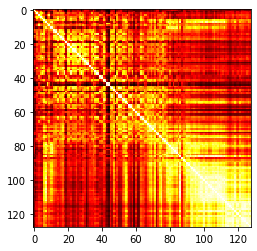

In [165]:
# plt.imshow(S, cmap='hot', interpolation='nearest')
# plt.show()
# print(S.shape)

In [14]:
def retrieveNearestK(query, db, k):
    sims = list()
    for entry in db:
        sim = query.cos_sim(entry)
        sims.append((entry.id, sim))
    sims.sort(key=lambda tup: tup[1], reverse=True)
    neighbors = list()
    for i in range(k):
        neighbors.append(sims[i][0])
    return neighbors        

In [24]:
def get_accuracy(db, queries): #lists of SongEntry's
    num_correct = 0
    k = 4
    for query in queries:
        nearestK = retrieveNearestK(query=query, db=db, k=k)
        for id in nearestK:
            print('query id: ' + str(query.id) + ', db id: ' + str(id))
            if (id == query.id):
                num_correct += 1
    total = len(queries) * k
    return num_correct / total

In [23]:
data_dir = os.path.join(os.getcwd(), '..\\data\\')
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
songDB = []
queries = []
for data_file in data_files:
    y, sr = librosa.load(data_file, duration=10)
    a = SongEntry(y, sr, data_file)
    queries.append(a)
    for i in range(1, 5):
        y, sr = librosa.load(data_file, duration=10, offset=i * 10)
        a = SongEntry(y, sr, data_file)
        songDB.append(a)
print(str(len(queries)) + ' query samples and ' + str(len(songDB)) + ' DB samples saved')

6 query samples and 24 DB samples saved


In [25]:
accuracy = get_accuracy(db=songDB, queries=queries)
print('Accuracy: ' + str(accuracy))

query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-allthat.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-badass.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-badass.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-b

In [166]:
db_bs_list = []
query_bs_list = []
for i in range(len(query_y)):
    y = query_y[i]
    sr = query_sr[i]
    S = sim_matrix(librosa.feature.melspectrogram(y=y, sr=sr))
    query_bs_list.append()
    

spectrogram1 = librosa.feature.melspectrogram(y=y1, sr=sr1)
spectrogram2 = librosa.feature.melspectrogram(y=y2, sr=sr2)
S = sim_matrix(spectrogram)
S1 = sim_matrix(spectrogram1)
S2 = sim_matrix(spectrogram2)
bs = beat_spectrum(y, sr, S)
bs1 = beat_spectrum(y1, sr1, S1)
bs2 = beat_spectrum(y2, sr2, S2)

In [168]:
print('Rhythmic similarity: ' + str(1 - cosine(bs, bs1)))
print('Rhythmic similarity: ' + str(1 - cosine(bs, bs2)))

Rhythmic similarity: 0.9826929856225306
Rhythmic similarity: 0.8686287900096676


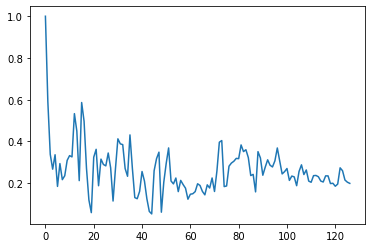

In [160]:
plt.plot(bs)